# Monte Carlo GPI

The idea behind Monte Carlo methods for RL is very straightforward, we want to do this via GPI, where we try to estimate the value of state-action pairs based on sampling. 

Essentialy we will run episodes by following a policy $\pi$(which can start as random). Then we will update an estimate of our $q$ function by the incrementing state-action pairs that occured in the episode:

$$ q(s, a) \leftarrow q(s, a) + \frac{G(s, a) - q(s, a)}{u(s, a) + 1}$$

Where $u(s, a)$ is the count of updates for this state-action pair, and $G(s, a)$ is the return we got in this episode after taking action $(s, a)$ for the first time(we will implement first visit Monte Carlo). This is just averaging over all first-visit results.

After that we update $\pi$ as an $\epsilon$-greedy policy over $q$. Note that we must have $\pi(s, a) > 0$ for all state-action pairs, else we can't guarantee enough exploration, and that's why we go with an $\epsilon$-greedy policy.

In this notebook we will see that the agent is capable of solving the problem, and how the exploration rate $\epsilon$ affects it. We won't spend much effort here as there are better ways to takle this problem.

In [1]:
import sys

sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt

from exploring_agents import MonteCarloAgent
from exploring_agents.training import run_episode, train_agent
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from utils.returns import returns_from_reward
from utils.policy import get_policy_rec
from notebooks.utils.experimentation import (
    get_exp_results,
    get_results,
    moving_average,
    get_summary_df,
)
from exploring_agents.commons.dacaying_functions import get_exp_decay
from notebooks.utils.worlds import (
    small_world_02,
)
from notebooks.utils.basics import basic_actions, basic_reward

np.random.seed(50)

# World

Monte Carlo is by no means an efficient method, so we will use a small deterministic word for this example.

In [2]:
gworld = small_world_02
print(get_world_str(gworld))

4    ✘          

3    ☠  █  █    

2               

1 █  █          

0 ⚐             

  0  1  2  3  4 


Lets what policy the agent can create after some runs in this world

In [3]:
epsilon=0.3
epsilon_2=0.1

agent = MonteCarloAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    epsilon=epsilon,
)

episode_lengths, episode_returns = train_agent(
    agent=agent, world=gworld, episodes=500
)

agent2 = MonteCarloAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    epsilon=epsilon_2,
)

episode_lengths_2, episode_returns_2 = train_agent(
    agent=agent2, world=gworld, episodes=500
)


pi_r = get_policy_rec(agent.policy, gworld, agent.actions)
pi_r_2 = get_policy_rec(agent2.policy, gworld, agent.actions)
print(f"""
Agent 1 policy

{get_policy_rec_str(pi_r, gworld)}

Agent 2 policy

{get_policy_rec_str(pi_r_2, gworld)}

"""
)


Agent 1 policy

 →  ✘  ←  ←  ← 

 ↓  ☠  █  █  ↑ 

 ↑  →  →  →  ↑ 

 █  █  ↑  ↑  ↑ 

 →  →  ↑  ←  ↑ 



Agent 2 policy

 →  ✘  ←  ←  ← 

 ↑  ☠  █  █  ↑ 

 ←  ←  ↓  ←  ↑ 

 █  █  ↓  →  ↑ 

 →  →  →  ↓  ↑ 






You can see the agents learn a path that is safe, but a little longer. That is because this is an on-policy agent, it learns optimizes the path according to policies it can explore. In this case this is a $\epsilon$-greedy poicy, with a very high exploration rate; which makes going near the trap a bad decision.

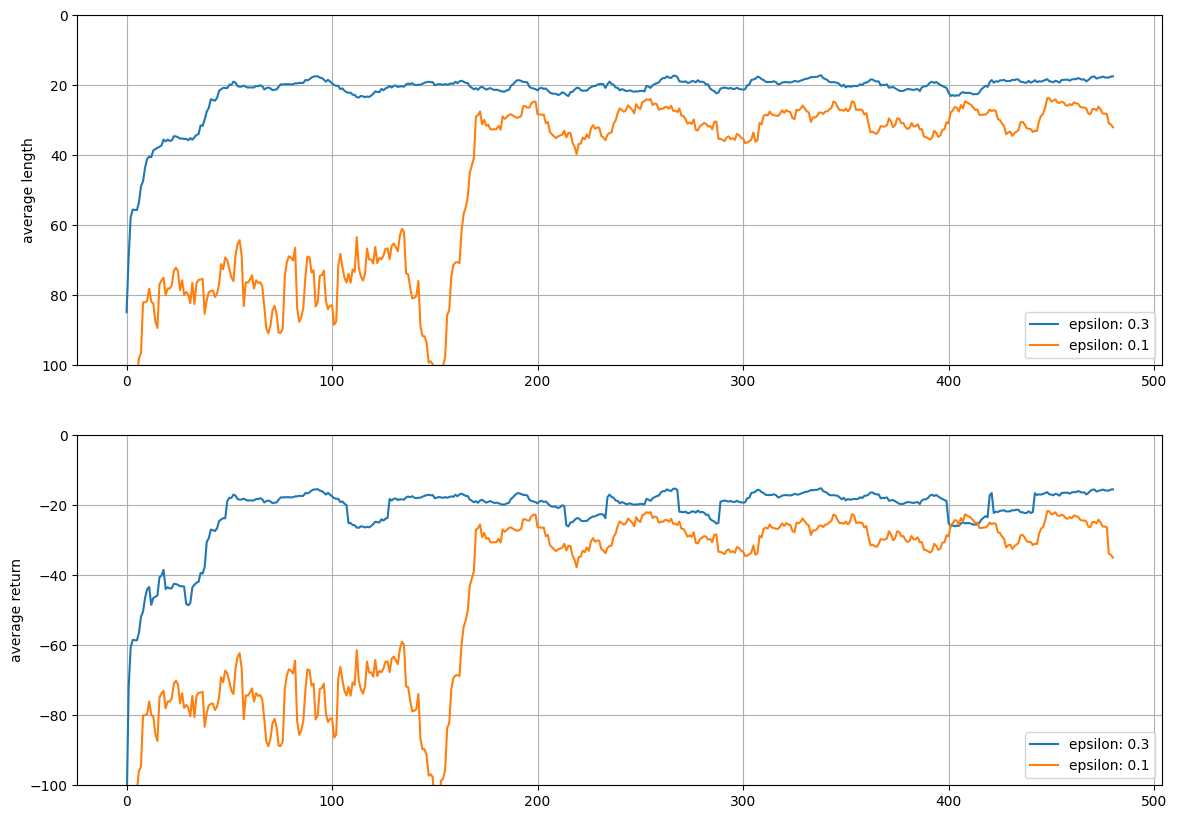

In [4]:
fig, axs = plt.subplots(2, figsize=(14, 10))

axs[0].plot(
    moving_average(episode_lengths, 20),
    label=f'epsilon: {epsilon}',
)
axs[0].plot(
    moving_average(episode_lengths_2, 20),
    label=f'epsilon: {epsilon_2}',
)



axs[0].set(ylabel="average length", ylim=[100, 0])
axs[0].grid()
axs[0].legend(loc="lower right")


axs[1].plot(
    moving_average(episode_returns, 20),
    label=f'epsilon: {epsilon}',
)
axs[1].plot(
    moving_average(episode_returns_2, 20),
    label=f'epsilon: {epsilon_2}',
)


axs[1].set(ylabel="average return", ylim=[-100, 0])
axs[1].grid()
axs[1].legend(loc="lower right");


The agent shows it is capable of improving! However... this clearly isn't ideal.

The agent takes a long time to learn(this is a very simple problem), in part because it makes poor use of the information it gets, and in part because it can't deal with the exploration vs exploitation problem.